## Denver Model
The notebook is to forecast number of house sales and listings in Denver months ahead with stacking models of Time series, Google Trends, and Economics Indicators.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
import pylab as pl
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV,RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from preprocessing import preprocessingMLS, featureEngineering
from getGoogleTrends import getGoogleTrendsData
import models
from models import baseModel, linearModel, rollingModel
from imp import reload

In [2]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

### 12.5 Update

1. Modularize the process
    - MLS preprocessing
    - google trends acquirement
    - Feature Engineering
    - Models: train-test, cross validation, nested cross validation
    
    
2. Overall prediction models stacking (Time series, Google trends, Economics)
    - Single model with google trends and economics features (not used)
    - **Linear Combination of Time Series prediction and Google Trends model (used)**
    - **Boosting with Economics data (used)**
    - Time series model using other features (not used)
    - **Predict 6 months ahead: Predict 3 months ahead with stacking model, and another 3 months ahead using time series**

In [28]:
#url = 'https://drive.google.com/file/d/141cuFgiBIVw0fsMztnJNoXLcud72DCBt/view?usp=sharing'
#path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
#pd.read_csv(path)

In [34]:
#get monthly data of number of listings, number of sales, and sales price
process = preprocessingMLS('data/denver_listing_dates.csv')
monthData = process.get_monthly_data(columns=['count_sale','count_list','sale_price'],start_date='2016-03', end_date='2020-09')


In [35]:
#get google trends data from API
#----------------------------------------------------
#gt = getGoogleTrendsData(geo='US-GA',city='Atlanta')
#trend = gt.getData(times=10,date='2016-03-01 2020-09-30',scaled=True)
#trend.to_csv('google_trends_atlanta_scaled.csv')
#----------------------------------------------------
trend = pd.read_csv('google_trends_scaled.csv')

In [36]:
#get economics indicator features
econ = pd.read_csv('econ_data.csv')
#econ.head()

In [37]:
#merge three dataframes
merged = pd.merge(monthData, trend).drop(['Unnamed: 0'],axis=1)
#merged = pd.merge(merged,econ,how='left')
#merged.head()

In [38]:
#create lag features and one hot month features with featureEngineering
feature_column_names = merged.columns.delete(0)
fe = featureEngineering(merged,feature_column_names)
fe.create_lag_features(lag_num_list=[1,3])
fe.create_month_one_hot()
df = fe.get_dataFrame()
feature_column_names = fe.get_feature_names()
print(len(feature_column_names))

105


## 1. Predicting number of sales
### 1.1 train-test &  cross validation

In [39]:
target_col = 'count_sale'
horizon = 3
model = models.linearModel(df,horizon,target_col,feature_column_names)
train_X_std, test_X_std, train_y, test_y = model.get_train_test(test_size=0.2)
model.fit(train_X_std, train_y, standardise=True)
rst, y_pred_train, y_pred_test = model.model_preformance(train_X_std, test_X_std, train_y, test_y,'count_sale_target')

In [40]:
rst

{'r2_train': 0.9730618466395556,
 'r2_test': 0.2021074321282308,
 'mse_train': 68597.10523706512,
 'mse_test': 4852572.600451162,
 'cv_score': 324594.10670976725}

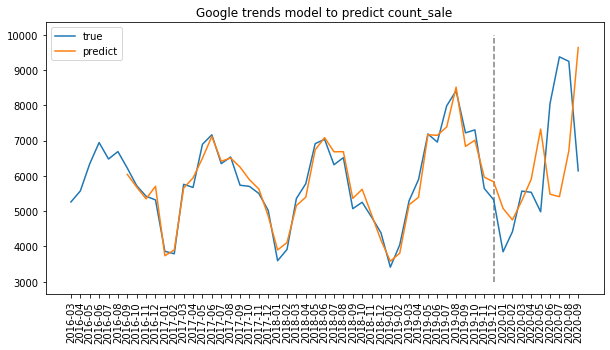

In [41]:
length_train = len(y_pred_train)
length_test = len(y_pred_test)
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
plt.plot(df.month.iloc[horizon+3:],np.append(y_pred_train, y_pred_test)+df[target_col].iloc[-length_train-length_test-horizon:-horizon],label='predict')
plt.vlines(df.month.values[-length_test],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [42]:
model.selected_features

array(['count_sale', 'zillow homes for sale', 'house prices',
       'best realtors', 'Homes in Denver', 'Homes near me_lag3',
       'zillow homes for sale_lag3', 'selling a house_lag3',
       'house valuations_lag1', 'real estate values_lag3',
       'how much is my house_lag1', 'rexhomes_lag1', 'zillow_lag1',
       'zillow_lag3', 'real estate agents_lag3', 'redfin_lag3',
       'realtor.com_lag1', 'realtor.com_lag3',
       'house appraisal in Denver_lag3', '02m', '03m', '04m', '08m',
       '10m', '12m'], dtype=object)

In [43]:
#most 5 important features in google trends model
#print(model.model.coef_)
print(model.selected_features[(-abs(model.model.coef_)).argsort()][:5])

['count_sale' '02m' 'zillow_lag3' 'zillow_lag1'
 'zillow homes for sale_lag3']


### 1.2 nested cross validation performance


In [13]:
horizon = 3
target_col = 'count_sale'
r = models.rollingModel(df,horizon,target_col,feature_column_names)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_google, scores_google =  r.rolling_prediction(start_predict_group,end_predict_group,horizon)
#TODO: ADD PREDICTION STD 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1680.3612001478357, tolerance: 832.6970727272728
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4192.04934666194, tolerance: 1498.02464
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3851.968754154599, tolerance: 1168.58688
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of

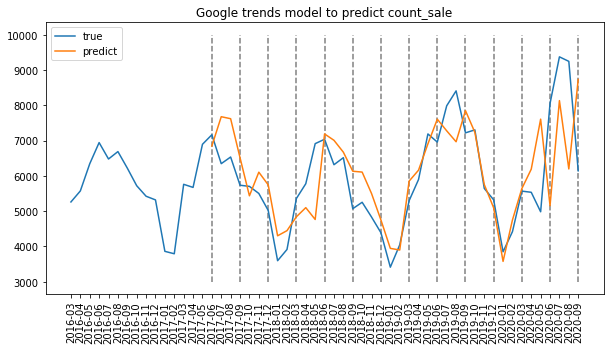

In [14]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_google[:len(preds_month)],label='predict')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [15]:
mean_squared_error(df[target_col][-len(preds_month):],preds_google[:len(preds_month)])

1283276.852093479

### 1.3 Time Series Model



In [138]:
'''
#for debug: simple predict model
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)
bmodel = models.BTSM()
bmodel.fit(sales,0)
pred_sales,scales, samples = bmodel.predict(np.ones(3))
'''

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_

In [309]:
horizon = 3
target_col = 'count_sale'
tsmodel = models.rollingTimeSeriesModel(df,horizon,target_col)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_ts, scores_ts, preds_scale_ts = tsmodel.rolling_prediction(start_predict_group,end_predict_group)

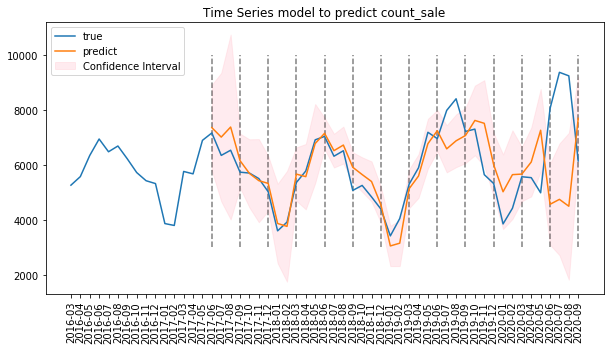

In [310]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_ts[:len(preds_month)],label='predict')
plt.fill_between(preds_month, np.array(preds_ts[:len(preds_month)])-2*np.array(preds_scale_ts[:len(preds_month)]),
                 np.array(preds_ts[:len(preds_month)])+2*np.array(preds_scale_ts[:len(preds_month)]),
                 color='pink', alpha=0.3, label='Confidence Interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Time Series model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [349]:
mean_squared_error(df[target_col][-len(preds_month):],preds_ts[:len(preds_month)])

1991735.4271432734

### 1.4 Linear Combination of Time Series and Google Trends, Boosting with Economics


In [351]:
# Linear Combination
preds_target = df[target_col].iloc[r.split_idx[start_predict_group]:]
lr = LinearRegression()
lr.fit(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T, preds_target)
intercept = lr.intercept_
coef = lr.coef_
print(lr.coef_)
print(lr.intercept_)

[ 0.99276086 -0.27277803]
1582.535832932499


In [346]:
#boosting
#residual error
preds_com = lr.predict(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T)
resid = preds_target - lr.predict(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T)


In [313]:
#create lag features and one hot month features with featureEngineering
econ = pd.read_csv('econ_data.csv')
econ_feature_column_names = econ.columns.delete(0)
fe = featureEngineering(econ,econ_feature_column_names)
fe.create_lag_features(lag_num_list=[1,2])
#fe.create_month_one_hot()
econ_df = fe.get_dataFrame()
econ_feature_column_names = fe.get_feature_names()
print(len(econ_feature_column_names))


63


In [314]:
#create data set in economics model
econ_sub = econ_df.iloc[-len(preds_month):,:]
econ_feature_column_names = econ_sub.columns[1:]
econ_sub['residual'] = resid.values

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [453]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

In [318]:
r_econ = models.rollingModel(econ_sub,horizon,'residual',econ_feature_column_names,lead_target=False)
end_predict_group = int(np.ceil(len(econ_sub)//horizon))
start_predict_group = 4
preds_boost, scores_boost = r_econ.rolling_prediction(start_predict_group,end_predict_group,horizon)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2183.1260882465376, tolerance: 897.1547129238181
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1498.7012445115815, tolerance: 759.4285406167603
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1634.1859056192998, tolerance: 876.1618022107693
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17571.239160473844, tolerance: 1675.556498693696
  positive)


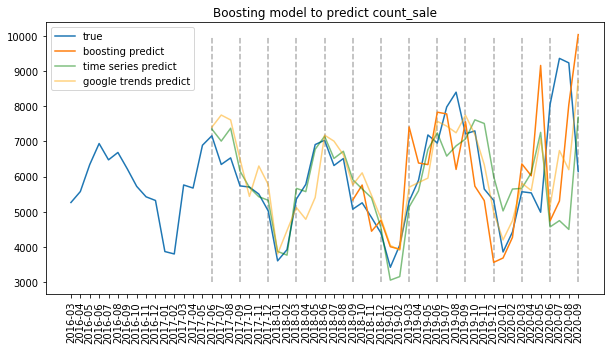

In [347]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
start_predict_group = 4
preds_month_boost = econ_sub.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month_boost,preds_boost[:len(preds_month_boost)]+preds_com[-len(preds_month_boost):],label='boosting predict')
plt.plot(preds_month,preds_ts[:len(preds_month)],label='time series predict',alpha=0.5,color='green')
plt.plot(preds_month,preds_google[:len(preds_month)],label='google trends predict',alpha=0.5,color='orange')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.3,linestyle='--')
plt.title('Boosting model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [348]:
mean_squared_error(df[target_col][-len(preds_month_boost):],preds_boost[:len(preds_month_boost)]+preds_com[-len(preds_month_boost):])

3224280.975547363

### 1.5 Predict 6 months ahead

First use boosting model to predict 3 months ahead, then use time series model to predict next 3 months.

In [46]:
horizon = 6
target_col = 'count_sale'
r = models.rollingModel(df,horizon,target_col,feature_column_names)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_google, scores_google =  r.rolling_prediction(start_predict_group,end_predict_group,horizon)
#TODO: ADD PREDICTION STD 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9029.128038475788, tolerance: 3559.9698000000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6900.937120711964, tolerance: 4054.99690967742
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12005.991457480643, tolerance: 8697.356979310345
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

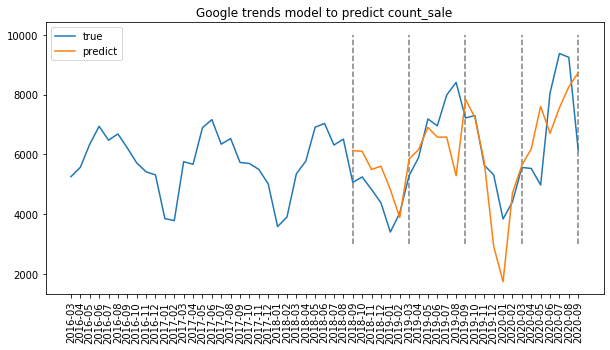

In [47]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_google[:len(preds_month)],label='predict')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [48]:
mean_squared_error(df[target_col][-len(preds_month):],preds_google[:len(preds_month)])

1950029.332388323

In [49]:
horizon = 6
target_col = 'count_sale'
tsmodel = models.rollingTimeSeriesModel(df,horizon,target_col)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 2
preds_ts, scores_ts, preds_scale_ts = tsmodel.rolling_prediction(start_predict_group,end_predict_group)

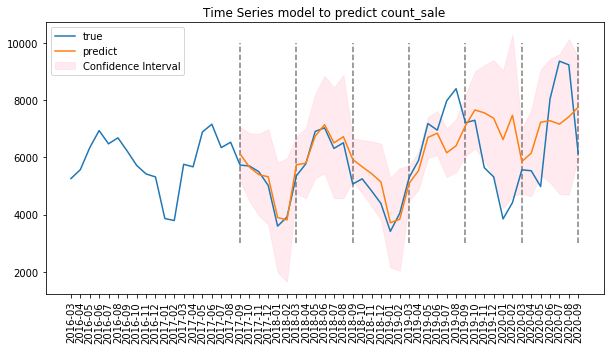

In [50]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_ts[:len(preds_month)],label='predict')
plt.fill_between(preds_month, np.array(preds_ts[:len(preds_month)])-2*np.array(preds_scale_ts[:len(preds_month)]),
                 np.array(preds_ts[:len(preds_month)])+2*np.array(preds_scale_ts[:len(preds_month)]),
                 color='pink', alpha=0.3, label='Confidence Interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Time Series model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [51]:
mean_squared_error(df[target_col][-len(preds_month):],preds_ts[:len(preds_month)])

1415544.2681425523

In [52]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

In [53]:
horizon = 6
split = 3
target_col = 'count_sale'
model = models.rollingCombinedModel(df,horizon,split, feature_column_names, target_col)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds = model.rolling_prediction(start_predict_group,end_predict_group)

[6, 12, 18, 24, 30, 36, 42, 48, 54]


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9029.128038475788, tolerance: 3559.9698000000003
  positive)


4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6900.937120711964, tolerance: 4054.99690967742
  positive)


5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6446.944846647042, tolerance: 5587.45481081081
  positive)


6
7
8


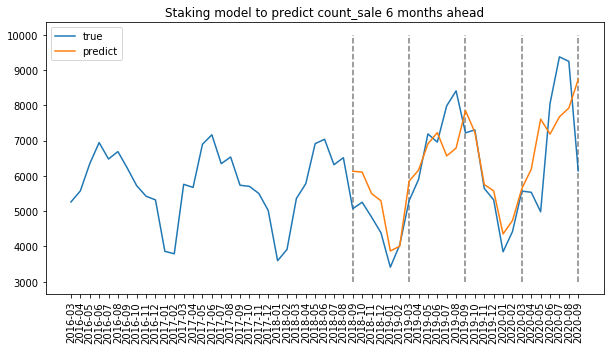

In [55]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds[:len(preds_month)],label='predict')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Staking model to predict '+target_col+' 6 months ahead')
plt.xticks(rotation=90)
plt.legend()

In [576]:
mean_squared_error(df[target_col][-len(preds_month):],preds[:len(preds_month)])

1136193.3833754205

In [ ]:
horizon = 6
target_col = 'count_sale'
r = models.rollingModel(df,horizon,target_col,feature_column_names)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_google, scores_google =  r.rolling_prediction(start_predict_group,end_predict_group,horizon)

In [11]:
model.selected_features

array(['count_list', 'Homes near me', 'zillow homes for sale',
       'real estate agents', 'best realtors', 'for sale by owner',
       'realtor.com', 'Homes in Denver', 'for sale by owner in Denver',
       'sale_price_lag1', 'townhomes for sale_lag3', 'Homes in_lag1',
       'Homes near me_lag1', 'selling a house_lag1',
       'house valuations_lag1', 'real estate values_lag1',
       'rexhomes_lag1', 'redfin_lag3', '03m', '09m'], dtype=object)

In [70]:
#most 5 important features in google trends model
#print(model.model.coef_)
print(model.selected_features[(-abs(model.model.coef_)).argsort()][:5])

['redfin_lag3' 'count_list' '03m' 'rexhomes_lag1' 'realtor.com']


In [60]:
r = models.rollingModel(df,3,'count_list',feature_column_names)

In [61]:
preds, scores = r.rolling_prediction(5,17,3)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8369.072829319608, tolerance: 4895.261523076922
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17632.87414828524, tolerance: 5417.814975
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25584.145936591587, tolerance: 9780.978040000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

In [ ]:
def model_split(x, y, time_cv, return_idx = False, cv=None): #cv is the k-fold number
    time_periods = len(x)
    if time_cv ==None:
        time_cv = int(np.ceil(time_periods//cv))  #time_cv is the time periods length in a single training set
    else: 
        cv = int(np.ceil(time_periods//time_cv))
        #print(cv)
    groups_train = {}
    groups_test = {}
    split_idx = []
    for i in range(cv-1):
        groups_train[i] = (x[:(i+1)*time_cv], y[:(i+1)*time_cv])
        groups_test[i] = (x[(i+1)*time_cv:(i+2)*time_cv], y[(i+1)*time_cv:(i+2)*time_cv])
        split_idx.append((i+1)*time_cv)
    groups_train[cv-1] = (x[:cv*time_cv], y[:cv*time_cv])
    groups_test[cv-1] = (x[cv*time_cv:], y[cv*time_cv:])
    split_idx.append(cv*time_cv) #split_idx is the index of the begining of test groups
    if return_idx == False:
        return groups_train, groups_test
    else:
        return groups_train, groups_test, split_idx

def model_evaluation(model, groups_train, groups_test, cv, show_CI_percent=None, bootstrap=1000):
    scores = []
    preds = []
    lower = []
    upper = []
    for i in range(cv):
        model_copy = model
        print('train time : ', i+1)
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred = model_copy.predict(groups_test[i][0])
        print(len(pred))
        print(len(groups_test[i][1]))
        mse = mean_squared_error(groups_test[i][1], pred)
        scores.append(mse)
        print(mse)
        preds.extend(list(pred))
        if show_CI_percent!=None:
            preds_boot = []
            train_length = len(groups_train[i][1])
            for j in range(bootstrap):
                indices = np.random.choice(np.arange(train_length),train_length, replace=True)
                model_copy = model
                model_copy.fit(groups_train[i][0][indices,:],groups_train[i][1][indices])
                preds_boot.append(model_copy.predict(groups_test[i][0]))
            #print(np.array(preds_boot).shape)
            upper.extend(list(np.percentile(np.array(preds_boot),100-show_CI_percent/2, axis=0)))
            lower.extend(list(np.percentile(np.array(preds_boot),show_CI_percent/2, axis=0)))
    if show_CI_percent == None:
        return preds, scores
    else:
        return np.array(preds), scores, np.array(upper), np.array(lower)

def nested_cv_evaluation(model,x,y,cv=5, start_pred=3, show_CI_percent = None):
    if show_CI_percent == None:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores = model_evaluation(model,groups_train, groups_test, cv)
        return preds, scores
    else:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores, upper, lower = model_evaluation(model, groups_train, groups_test,cv, show_CI_percent)
        return preds, scores, upper, lower



In [ ]:
class Linear_model(object):
    def __init__(self,feature_column_names):
        self.model = np.nan
        self.feature_column_names = feature_column_names
    def fit(self,x_train,y_train):
        self.lasso = LassoCV()
        self.model = RidgeCV()
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        self.lasso.fit(x_train_std, y_train)
        self.feature = np.arange(len(self.feature_column_names))[abs(self.lasso.coef_)>0] 
        #print(self.feature)
        #print(x_train_std.shape)
        self.model.fit(x_train_std[:,self.feature], y_train)
    def predict(self,x_test):
        #print(x_test)
        x_test_std = self.std.transform(x_test)
        return self.model.predict(x_test_std[:,self.feature])

class Linear_rolling_model(object):
    def __init__(self,feature_column_names,predict_horizon=6,start_fit=2):
        self.models = {}
        self.feature_column_names = feature_column_names
        self.predict_horizon = predict_horizon
        self.start_fit = start_fit
    def fit(self,x_train,y_train):
        for i in range(1,self.predict_horizon+1):
            self.x_train = x_train
            self.y_train = y_train
            self.models[i] = Linear_model(self.feature_column_names)
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].fit(x,y)
    def predict(self):
        y_pred = []
        for i in range(1,self.predict_horizon+1):
            pred_temp = self.models[i].predict(self.x_train[-self.start_fit:])
            y_pred.append(pred_temp[-1]+self.y_train.iloc[-1])
        return y_pred

In [ ]:
prediction_col = 'count_sale'
groups_train, groups_test, split_idx= model_split(df[feature_column_names],df[prediction_col],time_cv=3,return_idx=True)
split_idx

In [ ]:
len(df)

In [ ]:
pred_google_store = []
for i in range(4,18):
    #print(i)
    m = Linear_rolling_model(feature_column_names,predict_horizon=3,start_fit=3)
    x = groups_train[i][0]
    y = groups_train[i][1]
    m.fit(x,y) 
    pred_google = m.predict()
    pred_google_store.extend(pred_google)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(monthData.month, monthData['count_sale'],label ='true sales')
plt.plot(df.month[15:], pred_google_store[:-2],label='predict')
plt.vlines(df.month[split_idx[4:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google Trends model to predict the number of sales -- lead 1,2,3 three models')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [ ]:
mean_squared_error(df['count_sale'][15:],pred_google_store[:-2])

### 1. combine google trends and economics features in a single model

In [ ]:
merged = pd.merge(monthData, trend).drop(['Unnamed: 0'],axis=1)
merged = pd.merge(merged,econ,how='left')
#create lag features and one hot month features
feature_column_names = merged.columns.delete(0)
fe = featureEngineering(merged,feature_column_names)
fe.create_lag_features(lag_num_list=[1,3])
fe.create_month_one_hot()
df = fe.get_dataFrame()
feature_column_names = fe.get_feature_names()
print(len(feature_column_names))
model = linearModel(df,3,['count_sale'],feature_column_names)
train_X_std, test_X_std, train_y, test_y = model.get_train_test(test_size=0.3)
model.fit(train_X_std, train_y, standardise=True)
model.model_preformance(train_X_std, test_X_std, train_y, test_y,'count_sale_target')

In [ ]:
#most 5 important features in google trends model
print(model.model.coef_)
print(model.selected_features[(-abs(model.model.coef_)).argsort()][0][:10])
print(model.selected_features_no[(-abs(model.model.coef_)).argsort()][0][:10])

In [ ]:
model.selected_features_no

In [ ]:
std = StandardScaler()
X_std = std.fit_transform(df[feature_column_names])
#google_ = X_std[:,model.selected_features_no]*model.model.coef_

In [ ]:
google_ = X_std[:,[32,166,101]]

In [ ]:
prediction_col = 'count_sale'
groups_train, groups_test, split_idx= model_split(df[feature_column_names],df[prediction_col],cv=18,return_idx=True)
split_idx

In [ ]:
pred_google_store = []
for i in range(7,18):
    #print(i)
    m = Linear_rolling_model(feature_column_names,predict_horizon=3,start_fit=7)
    x = groups_train[i][0]
    y = groups_train[i][1]
    m.fit(x,y) 
    pred_google = m.predict()
    pred_google_store.extend(pred_google)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(monthData.month, monthData['count_sale'],label ='true sales')
plt.plot(df.month[24:], pred_google_store[:-2],label='predict')
plt.vlines(df.month[split_idx[7:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google Trends and economics model to predict the number of sales -- lead 1,2,3 three models')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [ ]:
# combined model performs better
mean_squared_error(df['count_sale'][24:],pred_google_store[:-2])

### 2. Boosting model

In [ ]:
#redisual after google trends prediction
resid = df['count_sale'][15:] - pred_google_store[:-2]
print(len(resid))

In [ ]:
econ = pd.read_csv('econ_data.csv')
feature_column_names = econ.columns.delete(0)
fe = featureEngineering(econ,feature_column_names)
fe.create_lag_features(lag_num_list=[1])
#fe.create_month_one_hot()
x_econ = fe.get_dataFrame()
feature_column_names = fe.get_feature_names()
print(feature_column_names)

In [ ]:
x_econ = x_econ.iloc[-40:,1:]
train_X, test_X, train_y, test_y = train_test_split(x_econ[feature_column_names],resid, test_size = 0.3, random_state=100, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)

In [ ]:
lr = LassoCV()
lr.fit(train_X_std, train_y)
selected_features_sale = feature_column_names[abs(lr.coef_)>0]
selected_features_sale_no = abs(lr.coef_)>0
selected_features_sale

In [ ]:
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_std[:,selected_features_sale_no], train_y)
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])

ridge_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y),
             'mse_train': mean_squared_error(train_y,y_pred_train),
             'mse_test': mean_squared_error(test_y,y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y, cv=5,scoring='neg_mean_squared_error').mean()}
ridge_rst

In [ ]:
pred_boosting = np.append(y_pred_train, y_pred_test)

In [ ]:
groups_train, groups_test, split_idx_boosting= model_split(x_econ[feature_column_names],resid,cv=13,return_idx=True)
split_idx_boosting

In [ ]:
len(feature_column_names)
groups_train[8][0].shape

In [ ]:
#rolling training 
pred_boosting_store = []
for i in range(11,13):
    #print(i)
    m = Linear_rolling_model(feature_column_names,predict_horizon=3,start_fit=2)
    x = groups_train[i][0]
    y = groups_train[i][1]
    m.fit(x,y) 
    pred_boosting = m.predict()
    pred_boosting_store.extend(pred_boosting)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(monthData.month, monthData['count_sale'],label ='true sales')
plt.plot(df.month[15:], pred_google_store[:-2],label='google predict')
plt.plot(df.month[15:], pred_google_store[:-2]+pred_boosting,label='boosting predict')
plt.vlines(df.month[split_idx[4:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Boosting model to predict the number of sales -- lead 1,2,3 three models')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [ ]:
mean_squared_error(df['count_sale'][15:],pred_google_store[:-2]+pred_boosting[:])

### 3. combine economics and google trends info in BSTS model

In [ ]:
import tensorflow.compat.v2 as tf
from tensorflow_probability import sts
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [ ]:
google_trends = google_[7:,:]

In [ ]:
for i in range(3):
    google_trends_effect.append() 
    sts.LinearRegression(design_matrix=tf.reshape(google_trends,(-1,1)),name='google_trends_effect')
tfp.sts.LinearRegression(design_matrix=tf.reshape(trend[col].values.astype(np.float64), (-1, 1)), name=col)

In [ ]:
df.columns

In [ ]:
google_trends_effect = []
for col in ['Homes in', 'townhouses in']:
    google_trends_effect.append(tfp.sts.LinearRegression(design_matrix=tf.reshape(df[col].values.astype(np.float64), (-1, 1)), name=col))

In [ ]:
google_trends_effect

In [ ]:
len(df['Homes in'])

In [ ]:
demand_model

In [ ]:
#Step 1:  evaluate the time series model
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    all_components = [trend,seasonal]

    model = sts.Sum(all_components, observed_time_series=observed_time_series)
    return model


def build_variational_posteriors(model, training_data, nsamples,
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(nsamples)
    
    return q_samples


class BTSM(object):
    def __init__(self,):
        self.model = 0
        self.q_samples = 0
        
    def fit(self,x_train, y_train,google_trends=None):
        self.train = x_train
        self.model = build_model(x_train,google_trends)
        self.q_samples = build_variational_posteriors(self.model, x_train,len(x_train),
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = False)
        
        
    def predict(self,x_test,num_samples=50):
        forecast_dist = tfp.sts.forecast(self.model, observed_time_series=self.train,
                                            parameter_samples=self.q_samples, num_steps_forecast=len(x_test))

        forecast_mean, forecast_scale, forecast_samples = (forecast_dist.mean().numpy()[..., 0],
                                                           forecast_dist.stddev().numpy()[..., 0],
                                                           forecast_dist.sample(num_samples).numpy()[..., 0])
        return forecast_mean, forecast_scale, forecast_samples
        



In [ ]:
google_[7:,0]

In [ ]:
demand_model = build_model(sales)

In [ ]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=demand_model)

In [ ]:
q_samples_demand_ = build_variational_posteriors(demand_model,sales[:-6],
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True,nsamples=30)

In [ ]:
print("Inferred parameters:")
for param in demand_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

In [ ]:
denver_forecast_dist = tfp.sts.forecast(demand_model, observed_time_series=sales[:-6],
                                            parameter_samples=q_samples_demand_, num_steps_forecast=3)

In [ ]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=sales,
    parameter_samples=q_samples_demand_,  
    num_steps_forecast=3)

In [ ]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    all_components = [trend, seasonal,google_trends_effect]
    model = sts.Sum(all_components, observed_time_series=observed_time_series)
    return model

In [ ]:
bmodel = BTSM()
bmodel.fit(sales[7:],0,google_[7:,0])
pred_sales,scale,samples = bmodel.predict(np.ones(6))

In [ ]:
def model_evaluation_ts(model, groups_train, groups_test, cv, show_CI_percent=None):
    scores = []
    preds = []
    upper = []
    lower = []
    for i in range(cv):
        model_copy = model
        print('train time : ', i+1)
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred, std, samples = model_copy.predict(groups_test[i][0])
        #mse = mean_squared_error(groups_test[i][1], pred)
        #scores.append(mse)
        #print(mse)
        preds.extend(list(pred))
        if show_CI_percent!=None:
            upper.extend(list(np.percentile(np.array(samples),100-show_CI_percent/2, axis=0)))
            lower.extend(list(np.percentile(np.array(samples),show_CI_percent/2, axis=0)))
    if show_CI_percent == None:
        return preds, scores
    else:
        return np.array(preds), scores, np.array(upper), np.array(lower)

def nested_cv_evaluation_ts(model,x,y,cv=5, start_pred=3, show_CI_percent = None):
    if show_CI_percent == None:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores = model_evaluation_ts(model, groups_train, groups_test, cv)
        return preds, scores
    else:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores, upper, lower = model_evaluation_ts(model, groups_train, groups_test,cv, show_CI_percent)
        return preds, scores, upper, lower




In [ ]:
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)

In [ ]:
google_trends = 

In [ ]:
groups_train, groups_test, split_idx = model_split(sales, sales, cv=18, return_idx=True)
split_idx

In [ ]:
bmodel = BTSM()
preds_ts,scores_ts, upper_ts, lower_ts = nested_cv_evaluation_ts(bmodel,sales,sales,cv=18,show_CI_percent=None)